## Final Model

To conduct microscopic analysis, we aim to examine the data points to conduct a more indepth error analysis. Specifically, we want to determine if there are any features that causes the model to misperform. 

We will only focus on the top 3 features as the coefficient for features after these 3 drops to near 0 making it difficult to evaluate if there is any great impact on the final result.

The top 3 features are log_annual_income and age and log_years_employed

Firstly, we split the dataset into misclassified (misclassified_df) and correctly classificied (classified_df). Where each row would be a data point with all its features. 

As these two datasets are large, we took a sample of 1000 from misclassified and classified and evaluted them based on the top 3 features.
age and log_years_employed did not have conclusive outcomes as misclassified data were distributed evenly. But log_annual_income we can see that it is concentrated in the middle portion. 

To make this clearer we plotted log_annual_income against age to better visualise. Showcasing once again that misclassified points are densely concentrated in the center. It was evenly distributed for age.

We also went more indepth by finding false negative data points by creating another dataframe fn_points and conducted similiar analysis. 

We tried to find specific instances where income is within the same range for misclassified and classified but it was hard to draw relevant conclusions due to the presence of many other features. All we could tell is that they were around the same income range. 


✅ Selected Threshold (Recall ≥ 0.5): 0.263
Precision: 0.231, Recall: 0.509, F1: 0.318

🔍 Top Features:
                                         Feature  Importance
0                              log_annual_income    0.219852
1                                            age    0.206959
2                             log_years_employed    0.136492
3                                    family_size    0.054706
4                                        own_car    0.027902
5                                          phone    0.024819
6                                         gender    0.021976
7                                     own_realty    0.020171
8                            income_type_Working    0.020006
9                                     work_phone    0.019239
10                             occupation_Others    0.016894
11  education_type_Secondary / secondary special    0.015777
12                         family_status_Married    0.015517
13               education_type_Higher edu

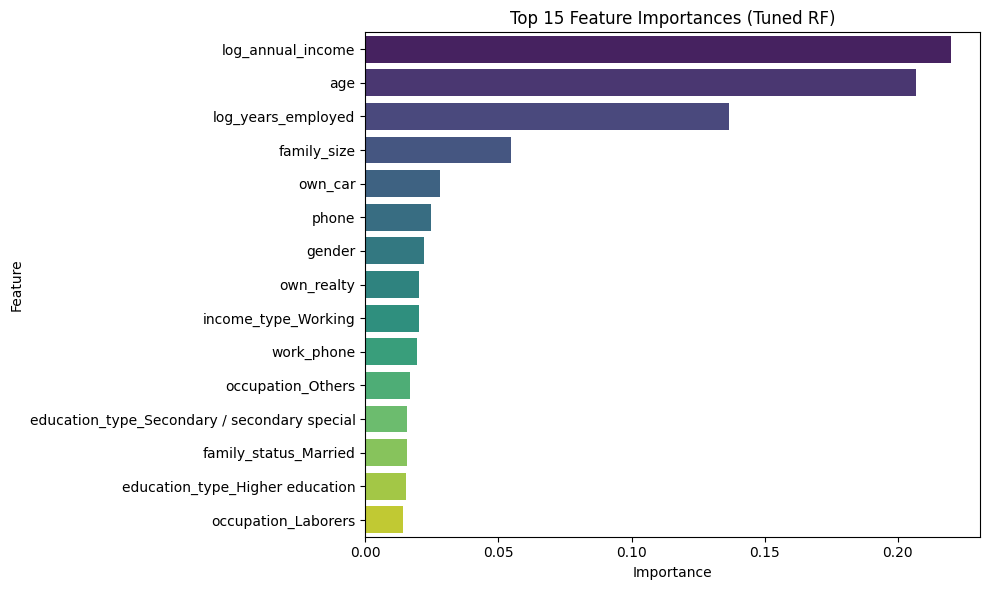

In [ ]:
### Chosen Hyperparameters based on RF + Borderline SMOTE with best F1 (scoring) where "Bad" class is positive
# Further Threshold tuning based on current best hyperparameters, trying to ensure recall for "Bad" class is >= 0.50
# Random Forest + Borderline SMOTE + Hyperparameters tuned + Threshold Tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set_noSMOTE.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

# Drop known redundant features
redundant_features = ['annual_income', 'years_employed']
X_train_reduced = X_train.drop(columns=redundant_features)
X_test_reduced = X_test.drop(columns=redundant_features)

# Use best model parameters directly
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators = 200,
        max_depth = None,
        min_samples_split = 2,
        min_samples_leaf = 1,
        max_features = 'sqrt',
        bootstrap = True,
        max_samples = 0.8,
        class_weight = None,
        random_state = 42
    ))
])

# Fit the best model
pipeline.fit(X_train_reduced, y_train)

# Compute predicted probabilities for class 1 = Bad
y_proba = pipeline.predict_proba(X_test_reduced)[:, 1]

# Use actual test labels (already 1 = Bad, 0 = Good)
y_test_binary = y_test

# Predict probabilities for class 1 ("Bad")
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_proba, pos_label=1)

# ✅ Set recall cutoff for Bad class (class 1)
recall_cutoff = 0.5

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Zip into list of (threshold, precision, recall, f1)
threshold_results = list(zip(thresholds, precision[:-1], recall[:-1], f1_scores[:-1]))

# Filter for thresholds where recall ≥ cutoff
qualified = [res for res in threshold_results if res[2] >= recall_cutoff]

if qualified:
    # Pick threshold with highest F1 score
    best_threshold, best_precision, best_recall, best_f1 = max(qualified, key=lambda x: x[3])
    print(f"\n✅ Selected Threshold (Recall ≥ {recall_cutoff}): {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
else:
    best_threshold = 0.5
    print(f"\n⚠️ No threshold achieves recall ≥ {recall_cutoff}. Using default 0.5.")
    
# Apply chosen threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)

# --------------------
# Feature Importance Plot
# --------------------
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train_reduced.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']

print("\n Top Features:")
print(feat_imp_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


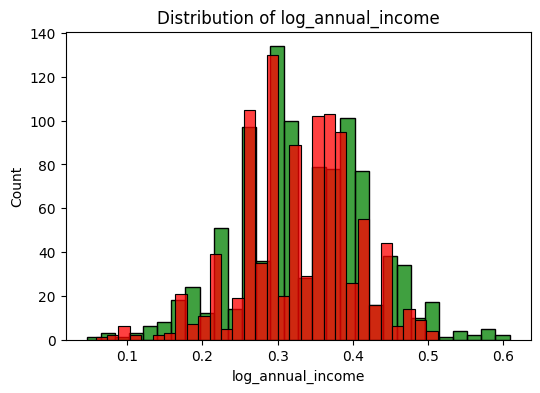

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


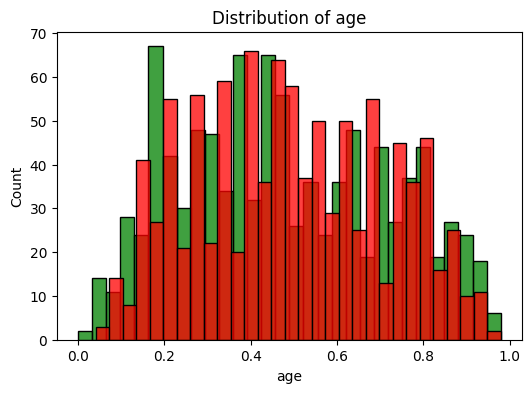

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


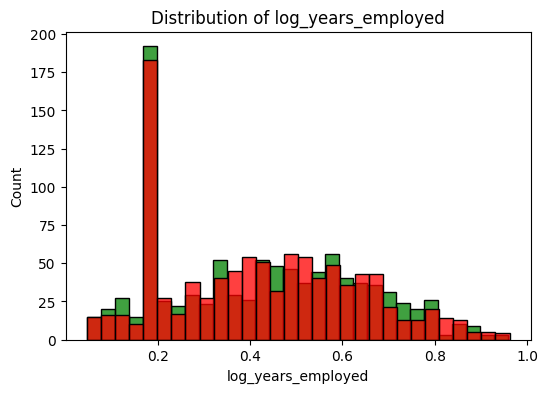

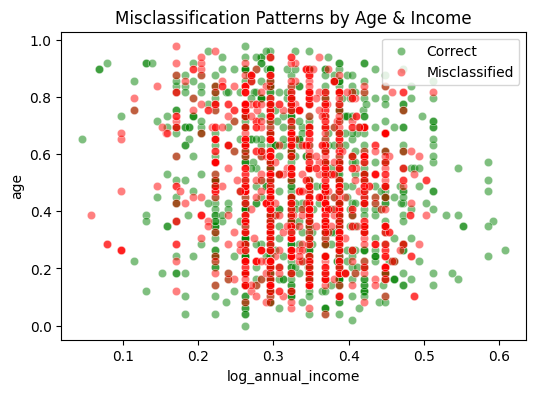

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


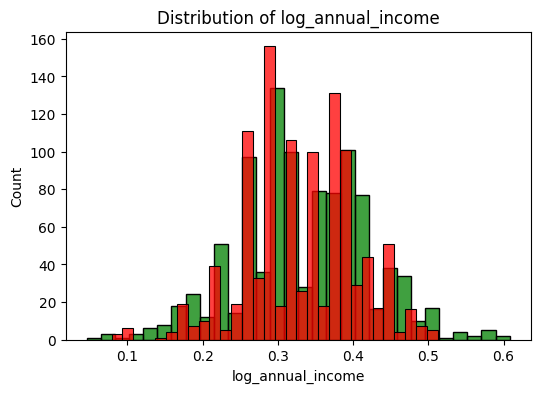

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


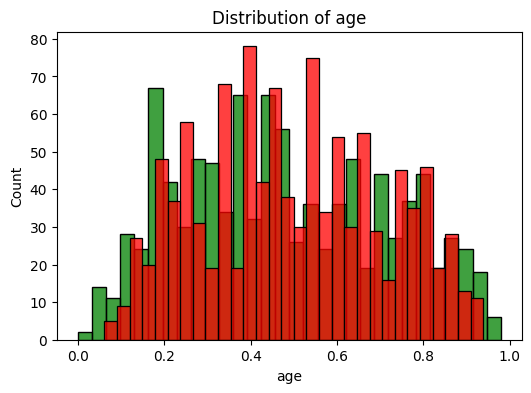

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


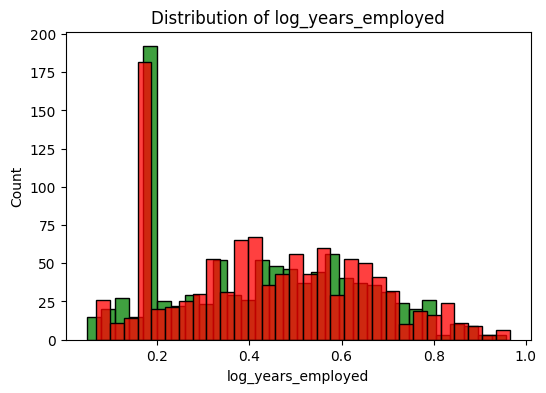

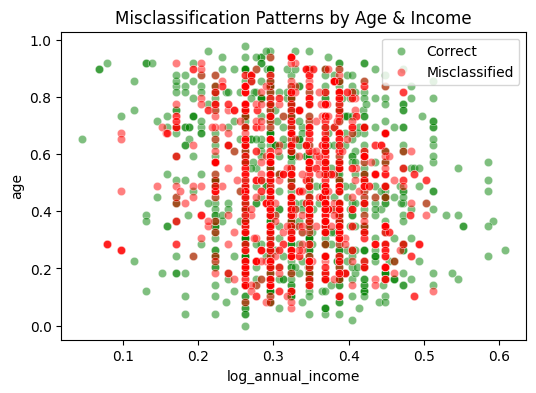

gender                                                 1
own_car                                                1
own_realty                                             1
work_phone                                             0
phone                                                  0
email                                                  0
family_size                                          2.0
age                                             0.591837
log_annual_income                               0.295808
log_years_employed                              0.627559
income_type_Pensioner                              False
income_type_State servant                          False
income_type_Student                                False
income_type_Working                                False
education_type_Higher education                    False
education_type_Incomplete higher                   False
education_type_Lower secondary                     False
education_type_Secondary / seco

In [ ]:
#for microscopic evaluation
import seaborn as sns
import matplotlib.pyplot as plt

#get index of misclassfied points
y_pred = y_pred_custom
y_true = y_test_binary
misclassified_ind = []
for i in range(len(y_pred)):
    if y_pred[i] != y_true.iloc[i]:
        misclassified_ind.append(X_test_reduced.index[i])
#create a misclassified df where there is all the misclassified data
misclassified_df = X_test_reduced.loc[misclassified_ind].copy()
misclassified_df['Prediction'] = y_pred[[X_test.index.get_loc(i) for i in misclassified_ind]]
misclassified_df['Actual'] = y_test.loc[misclassified_ind].values
#print(misclassified_df.head(10))

#get the correct samples to make comparision
classified_ind = []
for i in range(len(y_pred)):
    if y_pred[i] == y_true.iloc[i]:
        classified_ind.append(X_test_reduced.index[i])
#create a misclassified df where there is all the misclassified data
classified_df = X_test_reduced.loc[classified_ind].copy()
classified_df['Prediction'] = y_pred[[X_test.index.get_loc(i) for i in classified_ind]]
classified_df['Actual'] = y_test.loc[classified_ind].values
#print(classified_df.head(10))

sample_correct = classified_df.sample(1000, random_state=42)
sample_incorrect = misclassified_df.sample(1000, random_state=42)

#examining according to feature importance
for col in ['log_annual_income', 'age', 'log_years_employed']:
    plt.figure(figsize=(6, 4))
    sns.histplot(sample_correct[col], bins = 30, color='green')
    sns.histplot(sample_incorrect[col], bins = 30, color='red')
    plt.title(f'Distribution of {col}')
    plt.show()

#combining features
#top 2 based on feature importance
plt.figure(figsize=(6, 4))
sns.scatterplot(data=sample_correct, x='log_annual_income', y='age', color='green', label='Correct', alpha=0.5)
sns.scatterplot(data=sample_incorrect, x='log_annual_income', y='age', color='red', label='Misclassified', alpha=0.5)
plt.title("Misclassification Patterns by Age & Income")
plt.legend()
plt.show()

#examining false negatives
fn_points = misclassified_df[misclassified_df['Actual'] == 0]

for col in ['log_annual_income', 'age', 'log_years_employed']:
    plt.figure(figsize=(6, 4))
    sns.histplot(sample_correct[col], bins = 30, color='green')
    sns.histplot(fn_points[col], bins = 30, color='red')
    plt.title(f'Distribution of {col}')
    plt.show()

#print(fp_points.head(10))
plt.figure(figsize=(6, 4))
sns.scatterplot(data=sample_correct, x='log_annual_income', y='age', color='green', label='Correct', alpha=0.5)
sns.scatterplot(data=fn_points, x='log_annual_income', y='age', color='red', label='Misclassified', alpha=0.5)
plt.title("Misclassification Patterns by Age & Income")
plt.legend()
plt.show()

#finding exact points in dense areas that are misclassified and classified
#using one point of false positive as an example and comparing to positive
subset_correct = sample_correct[(sample_correct['log_annual_income'] >= 0.28) & (sample_correct['log_annual_income'] <= 0.30)]
subset_fn_points = fn_points[(fn_points['log_annual_income'] >= 0.28) & (fn_points['log_annual_income'] <= 0.30)]
print(subset_fn_points.head(10))
print(subset_correct.head(10))